<a href="https://colab.research.google.com/github/XbowSniper11/Internship/blob/main/Adversarial_Training_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import shutil
import glob
import pandas as pd
from PIL import Image
from tempfile import TemporaryDirectory
from collections import defaultdict, Counter
from sklearn import metrics
import pdb
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)

# Imagenet100 prep

In [ ]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d ambityga/imagenet100

! unzip "imagenet100.zip"

Streaming output truncated to the last 5000 lines.
  inflating: val.X/n01440764/ILSVRC2012_val_00000293.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00002138.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00003014.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00006697.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00007197.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009111.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009191.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009346.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009379.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00009396.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00010306.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00011233.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00011993.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00012503.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00013716.JPEG  
  inflating: val.X/n01440764/ILSVRC2012_val_00016

In [ ]:
# Function to create new folder if not exists
def make_new_folder(folder_name, parent_folder):

	# Path
	path = os.path.join(parent_folder, folder_name)

	# Create the folder
	# 'new_folder' in
	# parent_folder
	try:
		# mode of the folder
		mode = 0o777

		# Create folder
		os.mkdir(path, mode)
	except OSError as error:
		print(error)

# current folder path
current_folder = os.getcwd()

# list of folders to be merged
list_dir = ['train.X1', 'train.X2', 'train.X3', 'train.X4']

# enumerate on list_dir to get the
# content of all the folders ans store
# it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
	path = os.path.join(current_folder, val)
	content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will
# be merged
merge_folder = "train"

# merge_folder path - current_folder
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

	# loop through the contents of the
	# list of folders
	for contents in content_list[sub_dir]:

		# make the path of the content to move
		path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
		dir_to_move = os.path.join(current_folder, path_to_content )

		# move the file
		shutil.move(dir_to_move, merge_folder_path)


# Clean Training via Fixed Feature Extraction

In [ ]:
# Run if experiencing "FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints, fooling"
!rm -R /content/Imagenet100/train/.ipynb_checkpoints
!ls /content/Imagenet100/train/ -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/Imagenet100/train/.ipynb_checkpoints': No such file or directory
.	   n01537544  n01664065  n01729322  n01770081  n01806143  n01877812  n01978455	n02027492
..	   n01560419  n01665541  n01729977  n01770393  n01818515  n01883070  n01984695	n02028035
n01440764  n01582220  n01667114  n01734418  n01773157  n01819313  n01910747  n01985128	n02037110
n01443537  n01592084  n01667778  n01735189  n01773549  n01820546  n01914609  n01986214	n02051845
n01484850  n01601694  n01675722  n01739381  n01773797  n01824575  n01924916  n02002556	n02058221
n01491361  n01608432  n01677366  n01740131  n01774384  n01828970  n01930112  n02006656	n02077923
n01494475  n01614925  n01685808  n01742172  n01774750  n01829413  n01943899  n02007558
n01496331  n01622779  n01687978  n01749939  n01775062  n01833805  n01944390  n02011460
n01498041  n01630670  n01693334  n01751748  n01776313  n01843383  n01950731  n02012849
n01514668  n01632458  n01695060  n01753488  n01795545  n01847000  n01955084

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
clean_data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

clean_data_dir = '/content/Imagenet100'
clean_trainsets = {x: datasets.ImageFolder(os.path.join(clean_data_dir, x),
                                          clean_data_transforms[x], allow_empty=True)
                  for x in ['train', 'val']}
clean_trainloaders = {x: torch.utils.data.DataLoader(clean_trainsets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
clean_trainset_sizes = {x: len(clean_trainsets[x]) for x in ['train', 'val']}
class_names = clean_trainsets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

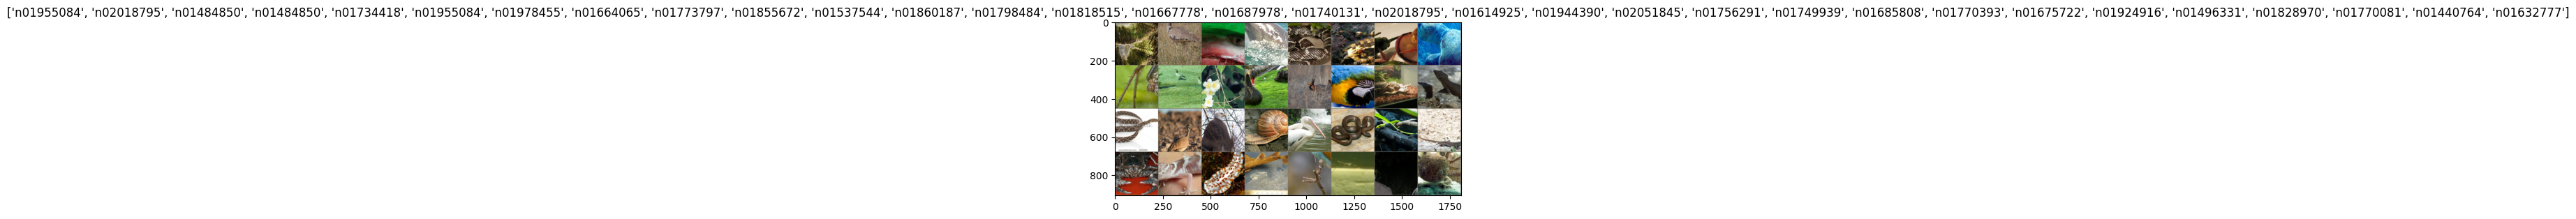

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(clean_trainloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model_clean(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in clean_trainloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / clean_trainset_sizes[phase]
                epoch_acc = running_corrects.double() / clean_trainset_sizes[phase]

                print(f'Clean {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model_clean(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(clean_trainloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# Model as fixed feature extractor

model_conv = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names) + 1) # 100 classes + 1 fooling class

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model_clean(model_conv, criterion, optimizer_conv, exp_lr_scheduler_conv, num_epochs=30)
torch.save(model_conv.state_dict(), "/content/model_conv_1.pt")
torch.save(optimizer_conv.state_dict(), "/content/optimizer_conv.pt")

Epoch 0/29
----------
Clean train Loss: 1.1129 Acc: 0.7836
Clean val Loss: 0.5449 Acc: 0.8464

Epoch 1/29
----------
Clean train Loss: 0.6311 Acc: 0.8333
Clean val Loss: 0.5042 Acc: 0.8588

Epoch 2/29
----------
Clean train Loss: 0.5838 Acc: 0.8395
Clean val Loss: 0.4971 Acc: 0.8540

Epoch 3/29
----------
Clean train Loss: 0.5607 Acc: 0.8425
Clean val Loss: 0.4965 Acc: 0.8586

Epoch 4/29
----------
Clean train Loss: 0.5402 Acc: 0.8463
Clean val Loss: 0.4923 Acc: 0.8598

Epoch 5/29
----------
Clean train Loss: 0.5342 Acc: 0.8470
Clean val Loss: 0.4899 Acc: 0.8628

Epoch 6/29
----------
Clean train Loss: 0.5255 Acc: 0.8490
Clean val Loss: 0.4894 Acc: 0.8650

Epoch 7/29
----------
Clean train Loss: 0.5148 Acc: 0.8512
Clean val Loss: 0.4803 Acc: 0.8648

Epoch 8/29
----------
Clean train Loss: 0.5157 Acc: 0.8515
Clean val Loss: 0.4825 Acc: 0.8638

Epoch 9/29
----------
Clean train Loss: 0.5156 Acc: 0.8514
Clean val Loss: 0.4816 Acc: 0.8652

Epoch 10/29
----------
Clean train Loss: 0.5137 Ac

In [ ]:
visualize_model_clean(model_conv)

plt.ioff()
plt.show()

NameError: name 'model_conv' is not defined

# Fooling Dataset Prep

In [ ]:
! unzip "generatedfooling.zip"

Streaming output truncated to the last 5000 lines.
  inflating: generated/train5/fooling/train5_5_ga_fooling_class_38.jpg  
  inflating: generated/train5/fooling/train5_12_ga_fooling_class_144.jpg  
  inflating: generated/train5/fooling/train5_0_ga_fooling_class_72.jpg  
  inflating: generated/train5/fooling/train5_11_ga_fooling_class_96.jpg  
  inflating: generated/train5/fooling/train5_0_ga_fooling_class_0.jpg  
  inflating: generated/train5/fooling/train5_1_ga_fooling_class_29.jpg  
  inflating: generated/train5/fooling/train5_10_ga_fooling_class_134.jpg  
  inflating: generated/train5/fooling/train5_1_ga_fooling_class_48.jpg  
  inflating: generated/train5/fooling/train5_10_ga_fooling_class_141.jpg  
  inflating: generated/train5/fooling/train5_10_ga_fooling_class_18.jpg  
  inflating: generated/train5/fooling/train5_10_ga_fooling_class_99.jpg  
  inflating: generated/train5/fooling/train5_0_ga_fooling_class_133.jpg  
  inflating: generated/train5/fooling/train5_6_ga_fooling_class_

In [ ]:
# current folder path
current_folder = "/content/generated/train"

# list of folders to be merged
list_dir = ['fooling0', 'fooling1', 'fooling2', 'fooling3', 'fooling4', 'fooling5', 'fooling6']

# enumerate on list_dir to get the
# content of all the folders ans store
# it in a dictionary
content_list = {}
for index, val in enumerate(list_dir):
	path = os.path.join(current_folder, val)
	content_list[ list_dir[index] ] = os.listdir(path)

# folder in which all the content will
# be merged
merge_folder = "fooling"

# merge_folder path - current_folder
# + merge_folder
merge_folder_path = os.path.join(current_folder, merge_folder)

# create merge_folder if not exists
make_new_folder(merge_folder, current_folder)

# loop through the list of folders
for sub_dir in content_list:

	# loop through the contents of the
	# list of folders
	for contents in content_list[sub_dir]:

		# make the path of the content to move
		path_to_content = sub_dir + "/" + contents

		# make the path with the current folder
		dir_to_move = os.path.join(current_folder, path_to_content )

		# move the file
		shutil.move(dir_to_move, merge_folder_path)

In [ ]:
# colab automatically creates .ipynb_checkpoints when creating new concatenated train directory, which raises an error when creating adv_trainsets
# remove .ipynb_checkpoints to solve this issue
!rm -R /content/generated/train/.ipynb_checkpoints
!ls /content/generated/train/ -a   #to make sure that the deletion has occurred

rm: cannot remove '/content/generated/train/.ipynb_checkpoints': No such file or directory
.	   n01531178  n01644900  n01728572  n01756291  n01798484  n01860187  n01978287	n02018795
..	   n01537544  n01664065  n01729322  n01770081  n01806143  n01877812  n01978455	n02027492
fooling    n01560419  n01665541  n01729977  n01770393  n01818515  n01883070  n01984695	n02028035
n01440764  n01582220  n01667114  n01734418  n01773157  n01819313  n01910747  n01985128	n02037110
n01443537  n01592084  n01667778  n01735189  n01773549  n01820546  n01914609  n01986214	n02051845
n01484850  n01601694  n01675722  n01739381  n01773797  n01824575  n01924916  n02002556	n02058221
n01491361  n01608432  n01677366  n01740131  n01774384  n01828970  n01930112  n02006656	n02077923
n01494475  n01614925  n01685808  n01742172  n01774750  n01829413  n01943899  n02007558
n01496331  n01622779  n01687978  n01749939  n01775062  n01833805  n01944390  n02011460
n01498041  n01630670  n01693334  n01751748  n01776313  n01843383  n

In [ ]:
def copy_subfolder_names(source_folder, destination_folder):
    # Get all subfolder names in the source folder
    subfolders = [f.name for f in os.scandir(source_folder) if f.is_dir()]

    # Create empty subfolders in the destination folder
    for subfolder in subfolders:
        new_folder_path = os.path.join(destination_folder, subfolder)
        os.makedirs(new_folder_path, exist_ok=True)
        print(f'Created folder: {new_folder_path}')

# Example usage
source_folder = '/content/Imagenet100/train'  # Replace with your source folder path
destination_folder = '/content/generated/test'  # Replace with your destination folder path

copy_subfolder_names(source_folder, destination_folder)

Created folder: /content/generated/test/n02051845
Created folder: /content/generated/test/n01484850
Created folder: /content/generated/test/n01537544
Created folder: /content/generated/test/n01984695
Created folder: /content/generated/test/n01739381
Created folder: /content/generated/test/n01773549
Created folder: /content/generated/test/n01756291
Created folder: /content/generated/test/n01833805
Created folder: /content/generated/test/n01798484
Created folder: /content/generated/test/n01955084
Created folder: /content/generated/test/n01843383
Created folder: /content/generated/test/n01698640
Created folder: /content/generated/test/n02018207
Created folder: /content/generated/test/n01728572
Created folder: /content/generated/test/n01795545
Created folder: /content/generated/test/n01632777
Created folder: /content/generated/test/n01877812
Created folder: /content/generated/test/n01695060
Created folder: /content/generated/test/n02037110
Created folder: /content/generated/test/n01914609


# Adversarial Training via Finetuning

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, special_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.special_transform = special_transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.file_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    self.file_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.classes[label] == "zooling" and self.special_transform:
            image = self.special_transform(image)
        elif self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
%rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
# %cp -r /content/Imagenet100/val /content/adversarial_trainset

In [ ]:
# %cp -r /content/generated/val/zooling /content/adversarial_trainset/val

In [ ]:
adv_data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# adv_trainfolder = "/content/adversarial_trainset/train"
# adv_trainset = CustomDataset(adv_trainfolder, adv_data_transform, clean_data_transforms['train'])
# adv_trainset = CustomImageDataset(adv_trainfolder, clean_data_transforms['train'], adv_data_transform)

adv_trainset = datasets.ImageFolder(root='/content/adversarial_trainset_TL/train', transform=adv_data_transform)
adv_trainloader = DataLoader(adv_trainset, batch_size=32, shuffle=True, num_workers=4)
adv_trainset_size = len(adv_trainset)


# adv_valfolder = "/content/adversarial_trainset/val"
# adv_valset = CustomDataset(adv_valfolder, adv_data_transform, clean_data_transforms['val'])
# adv_valset = CustomImageDataset(adv_valfolder, clean_data_transforms['val'], adv_data_transform)


adv_valset = datasets.ImageFolder(root='/content/adversarial_trainset_TL/val', transform=adv_data_transform)
adv_valloader = DataLoader(adv_valset, batch_size=32, shuffle=True, num_workers=4)
adv_valset_size = len(adv_valset)

class_names_adv = adv_trainset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(adv_trainset_size, adv_valset_size)
print(class_names_adv)
print(len(class_names_adv))

139100 8000
['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475', 'n01496331', 'n01498041', 'n01514668', 'n01514859', 'n01531178', 'n01537544', 'n01560419', 'n01582220', 'n01592084', 'n01601694', 'n01608432', 'n01614925', 'n01622779', 'n01630670', 'n01632458', 'n01632777', 'n01644900', 'n01664065', 'n01665541', 'n01667114', 'n01667778', 'n01675722', 'n01677366', 'n01685808', 'n01687978', 'n01693334', 'n01695060', 'n01698640', 'n01728572', 'n01729322', 'n01729977', 'n01734418', 'n01735189', 'n01739381', 'n01740131', 'n01742172', 'n01749939', 'n01751748', 'n01753488', 'n01755581', 'n01756291', 'n01770081', 'n01770393', 'n01773157', 'n01773549', 'n01773797', 'n01774384', 'n01774750', 'n01775062', 'n01776313', 'n01795545', 'n01796340', 'n01798484', 'n01806143', 'n01818515', 'n01819313', 'n01820546', 'n01824575', 'n01828970', 'n01829413', 'n01833805', 'n01843383', 'n01847000', 'n01855672', 'n01860187', 'n01877812', 'n01883070', 'n01910747', 'n01914609', 'n01924916', 'n01930112',

In [ ]:
def val(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_losses = []

    criterion = nn.CrossEntropyLoss(reduction='none')  # Define the loss function

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_losses.extend(loss.cpu().numpy())

    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)
    all_losses = torch.tensor(all_losses)

    # Separate predictions, labels, and losses for the first 100 classes and the last class
    first_100_mask = all_labels < 100
    last_class_mask = all_labels == 100

    first_100_preds = all_preds[first_100_mask]
    first_100_labels = all_labels[first_100_mask]
    first_100_losses = all_losses[first_100_mask]

    last_class_preds = all_preds[last_class_mask]
    last_class_labels = all_labels[last_class_mask]
    last_class_losses = all_losses[last_class_mask]

    # Calculate accuracy for the first 100 classes
    acc_first_100 = metrics.accuracy_score(first_100_labels, first_100_preds)
    # Calculate loss for the first 100 classes
    loss_first_100 = first_100_losses.mean().item()

    # Calculate accuracy for the last class
    acc_last_class = metrics.accuracy_score(last_class_labels, last_class_preds)
    # Calculate loss for the last class
    loss_last_class = last_class_losses.mean().item()

    return acc_first_100, loss_first_100, acc_last_class, loss_last_class

In [ ]:
def train_model_adv(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    if not os.path.exists('confusion_matrices'):
        os.makedirs('confusion_matrices')

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        all_targets = []
        all_predictions = []

        labels_array = {i: [] for i in range(len(class_names_adv))}
        predictions_array = {i: [] for i in range(len(class_names_adv))}

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, (inputs, labels) in enumerate(adv_trainloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # optimizer.zero_grad()

                # forward
                # with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                # loss = criterion(outputs, labels)

                for label, pred in zip(labels, preds):
                    labels_array[label.item()].append(label.item())
                    predictions_array[label.item()].append(pred.item())
                # pdb.set_trace()
                # backward + optimize
                # loss.backward()
                # optimizer.step()

                all_targets.extend(labels.cpu().numpy())
                all_predictions.extend(preds.cpu().numpy())

                if (batch_idx) % (len(adv_trainloader) // 10) == 0 or (batch_idx + 1) == len(adv_trainloader):
                    cm = metrics.confusion_matrix(all_targets, all_predictions)

                    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize as needed
                    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
                    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.0f')

                    ax.set_xticks(np.arange(len(cm)))
                    ax.set_yticks(np.arange(len(cm)))
                    ax.set_xticklabels(np.arange(len(cm)), rotation=90, fontsize=8)
                    ax.set_yticklabels(np.arange(len(cm)), fontsize=8)
                    ax.tick_params(axis='x', pad=10)
                    ax.tick_params(axis='y', pad=10)

                    plt.tight_layout()
                    plt.savefig(f'confusion_matrices/confusion_matrix_epoch{epoch+1}_batch{batch_idx+1}.png', dpi=300)
                    plt.close()

                # statistics
                # running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # scheduler.step()

            train_epoch_loss = running_loss / adv_trainset_size
            train_epoch_acc = running_corrects.double() / adv_trainset_size

            print(f'Adv + clean train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
            print()

            # Validate
            acc_clean, loss_clean, acc_adv, loss_adv = val(model, adv_valloader, device)
            print(f'Clean val Loss: {loss_clean} Acc: {acc_clean}')
            print(f'Adv val Loss: {loss_adv}, Acc: {acc_adv}')
            if acc_adv > best_acc:
                best_acc = acc_adv
                torch.save(model.state_dict(), best_model_params_path)
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best adv val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)


            with torch.no_grad():
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names_adv[preds[j]]} (class_idx {preds[j]})')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
def pred_img(model, img_path, transform):
    # load your image(s)
    img = Image.open(img_path)

    # Transform
    input = transform(img)

    # unsqueeze batch dimension, in case you are dealing with a single image
    input = input.unsqueeze(0)
    input = input.to(device)
    # Set model to eval
    model.eval()

    output = model(input)
    _, pred = torch.max(output, 1)
    print(class_names_adv[pred[0].cpu().numpy()])

In [ ]:
# Finetuning model

model_ft = torchvision.models.resnet50()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 101) # 100 ImageNet100 classes + 1 "fooling" class

model_ft.load_state_dict(torch.load("/content/model_conv_1.pt"))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Test model before training
acc_clean, loss_clean, acc_adv, loss_adv = val(model_ft, adv_valloader, device)
print(f'Clean val Loss: {loss_clean} Acc: {acc_clean}')
print(f'Adv val Loss: {loss_adv}, Acc: {acc_adv}')

Clean val Loss: 0.5570917725563049 Acc: 0.845
Adv val Loss: 27.395362854003906, Acc: 0.0


In [ ]:
%rm -rf /content/confusion_matrices

NameError: name 'imshow' is not defined

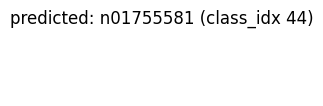

In [ ]:
visualize_model(model_ft, adv_trainloader, num_images=10)

In [ ]:
# Adversarial training
pred_img(model_ft, '/content/adversarial_trainset/train/zooling/train0_0_ga_fooling_class_0.jpg',adv_data_transform)
model_ft = train_model_adv(model_ft, criterion, optimizer_ft, exp_lr_scheduler_ft, num_epochs=10)
torch.save(model_ft.state_dict(), "/content/model_ft.pt")

n01440764
Epoch 0/9
----------


KeyboardInterrupt: 